In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px
import pandas as pd
import plotly.io as io 
io.renderers.default = "browser"

from axion_functions import *

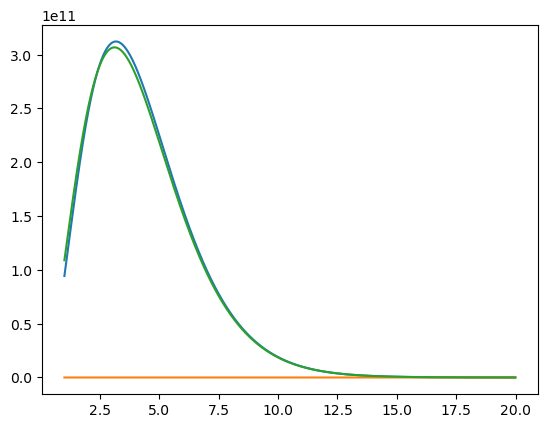

In [2]:
def primakoff_flux(Energy_array, coupling=2e-10, m_a = 0.001):
    '''m_a is in keV; initial value is indeed 1 eV'''
    lmda = (coupling/(1e-10))**4
    phi_e0 = 4.2e10
    pa2 = Energy_array**2 - m_a**2

    dpde_list = []
    for E in Energy_array:
        if np.isinf(E):
            dpde_list.append(0)
        else:
            val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)
            dpde_list.append(max(0, val))
    return np.array(dpde_list)

def coalescence_flux(Energy_array, coupling = 2e-10, m_a = 1e-3):
    lmda = (coupling/(1e-10))**4
    phi_e0 = 1.68e9

    dpde_list = []
    for E in Energy_array:
        if np.isinf(E) or E<m_a:
            dpde_list.append(0)
        else:
            val = np.sqrt(lmda)*phi_e0*m_a**4*np.sqrt(E**2 - m_a**2)*(1+0.0006*E**3+10/(E**2+0.2))*np.exp(-E)
            dpde_list.append(val)
    return np.array(dpde_list)

fig,ax = plt.subplots()

e_axis  = np.arange(1,20, 0.01)
f_axis1 =   primakoff_flux(e_axis, m_a = 0.01)
f_axis2 = coalescence_flux(e_axis, m_a = 0.01)
f_axis3 = make_dpde(e_axis)
ax.plot(e_axis, f_axis1)
ax.plot(e_axis, f_axis2)
ax.plot(e_axis, f_axis3)

plt.show()

^Realistically, the primakoff and parametrised fluxes are the same for any sub-keV scale axion mass and photon coalescence is much smaller than primakoff

In [19]:
integrated_list = []
mass_axis = np.logspace(-6, 0, 100)
for masses in mass_axis:
    flux = primakoff_flux(e_axis, m_a = masses)
    integrated_list.append(np.trapz(flux, e_axis))


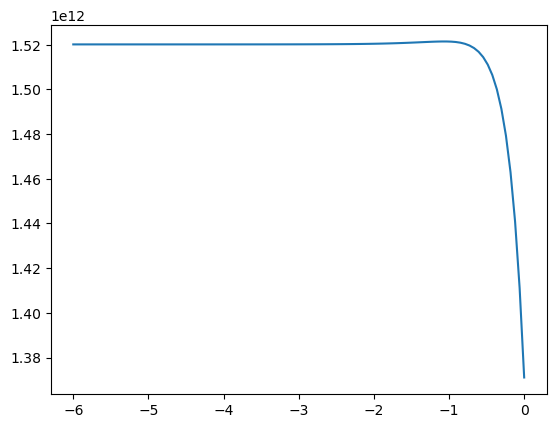

In [20]:
plt.plot(np.log10(mass_axis), integrated_list)

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)
me_hca

258.9605074819228

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)
me_hca

# Define unknown constants
g_agg = 2e-10 #g_agg (axion-photon-photon) coupling constant; in GeV^(-1) (for photon coalescence)
g_ag = 1e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
lmda = (g_agg/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value #Crystal volume, in AA^3
vol = ((50*unit.kg/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper

In [4]:
((vol*unit.AA**3).to(unit.cm**3))**(1/3)

<Quantity 23.88368383 cm>

In [5]:
gag_unit = g_ag*(unit.GeV)**(-1)
gag_unit.to(unit.keV**(-1))

<Quantity 1.e-16 1 / keV>

In [6]:
(g_ag*unit.GeV**(-1)).to(unit.keV**(-1))

<Quantity 1.e-16 1 / keV>

In [3]:
#Define useful functions
def make_hkl(max_h=5,max_k=5,max_l=5, s=False):
    '''This might need to be remade based on what the "primitives" are. Condition is h,k,l must be even.
    F mandates h,k,l share a parity, and S mandates h+k+l is even'''
    full_arr = list(itertools.product(range(max_h), range(max_k), range(max_l)))
    if s:
        filter_func = lambda triple: (triple[0]%2 == triple[1]%2) & (triple[0]%2 == triple[2]%2) & (triple[0]%2 == 0)
        return np.array(list(filter(filter_func, full_arr)))[1:]
    else:
        filter_func = lambda triple: (triple[0]%2 == triple[1]%2) & (triple[0]%2 == triple[2]%2)
        return np.array(list(filter(filter_func, full_arr)))[1:]


def make_hkl_s(max_h=5,max_k=5,max_l=5):
    '''hkl array, where the only condition is h+k+l must be even'''
    full_list = list(itertools.product(range(max_h),range(max_k),range(max_l)))
    filter_func = lambda triple: sum(triple)%2 == 0
    return np.array(list(filter(filter_func, full_list)))[1:] #remove (0,0,0)
    

def mod2(vec3):
    '''Returns the dimensionless magnitude of an array of vectors in the (h,k,l) basis. Factor of 2pi/a has to be multiplied manually'''
    return 3*(vec3[:,0]**2 + vec3[:,1]**2 + vec3[:,2]**2) - 2*(vec3[:,0]*vec3[:,1] + vec3[:,1]*vec3[:,2] + vec3[:,2]*vec3[:,0])

def gdotk(hkl_arr):
    '''Returns gHAT dot kHAT, assuming kHat is in the cartesian x direction'''
    return (-hkl_arr[:,0]+hkl_arr[:,1]+hkl_arr[:,2])/np.sqrt(mod2(hkl_arr))

def w_func(Ea, dVector = False, Delta=1.5, E1=1, E2=6):
    '''Returns array of W(Ea, Delta, E1, E2) where everything is in keV. Infinite Ea is dealt with'''
    w_list = []
    if dVector:
        entangle = np.dstack((Ea, Delta))
        for index in range(entangle.shape[1]):
            E = entangle[0,index,0]
            D = entangle[0,index,1]
            if np.isinf(E) or E<0:
                w_list.append(0)
            else:
                w = (1/2)*(erf((E-E1)/(np.sqrt(2)*D)) - erf((E-E2)/(np.sqrt(2)*D)))
                w_list.append(w)
    else:
        for E in Ea:
            if np.isinf(E) or E<0:
                w_list.append(0)
            else:
                w = (1/2)*(erf((E-E1)/(np.sqrt(2)*Delta)) - erf((E-E2)/(np.sqrt(2)*Delta)))
                w_list.append(w)
    return np.array(w_list)

def make_dpde(Energy_array):
    '''Creates dPhi/dE for the parametrised blackbody-like form appearing in older papers. Assumes no axion mass.
    Units of cm^(-2) s^(-1) keV^(-1)'''
    dpdt_list = []
    for E in Energy_array:
        if np.isinf(E):
            dpdt_list.append(0)
        else:
            dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))
    return np.array(dpdt_list)

def FA_q(q2, Z=51):
    '''Returns form factor given an input in AA^(-2)'''
    qme = q2/0.1308
    A = 184.15*np.exp(-1/2)*Z**(-1/3)
    return Z*A**2*qme/(1+A**2*qme)

def make_delta(energy):
    '''Returns Delta (approx 15%*sqrt(E)*E) for an energy array, setting infinities and negatives to zero'''
    output = []
    for E in energy:
        if E<0 or np.isinf(E):
            output.append(0)
        else:
            output.append(0.15463505424062166*np.sqrt(E/1000)*E)
    return np.array(output)

def hkl_to_cart(hkl_array):
    '''Converts from hkl basis to cartesian basis, ignoring factor of 2pi/a'''
    x_axis = - hkl_array[:,0] + hkl_array[:,1] + hkl_array[:,2] 
    y_axis =   hkl_array[:,0] - hkl_array[:,1] + hkl_array[:,2] 
    z_axis =   hkl_array[:,0] + hkl_array[:,1] - hkl_array[:,2] 
    return np.stack((x_axis, y_axis, z_axis), axis=1)

def cart_mag(vec):
    '''Returns cartesian magnitude of a 1d n-vector'''
    return np.sqrt(np.sum(vec**2))

def gdotk_cart(g_arr, k_vec):
    '''Cartesian dot product for 2d array g_arr and 1d 3-vector k_vec. Does not convert to unit vectors'''
    output_list = []
    for g_vec in g_arr:
        output_list.append(g_vec[0]*k_vec[0] + g_vec[1]*k_vec[1] + g_vec[2]*k_vec[2])
    return np.array(output_list)

Define the possible values of $(h,k,l)$ and therefore $\vec{G} = \frac{2\pi}{a}(h,k,l)$. Define also $|\vec{G}|^2$ and therefore $F_A(q)$ and $\hat{G}$

In [8]:
hkl = np.array(make_hkl_s(max_h = 6, 
                          max_k = 6,
                          max_l = 6)) #Indexed to [25,2], removing trivial case
# compare with (h+k+l) even against (h,k,l) all add/all even

g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
FAq = FA_q(mod2_g)

ginv_array = 1/mod2_g

ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

ghat = g_arr*np.sqrt(ginv_replicant)

In [9]:
FAq

array([50.99931521, 50.9998288 , 50.99794567, 50.9996576 , 50.99987915,
       50.99931521, 50.9994864 , 50.99981324, 50.9996576 , 50.99977173,
       50.99988587, 50.9998288 , 50.99981324, 50.9998716 , 50.99987915,
       50.99988587, 50.99991782, 50.99794567, 50.9996576 , 50.99987915,
       50.99794567, 50.99897282, 50.99977173, 50.99897282, 50.99958912,
       50.99985326, 50.9996576 , 50.99958912, 50.99979456, 50.99977173,
       50.99979456, 50.99987915, 50.99987915, 50.99985326, 50.99987915,
       50.99931521, 50.9994864 , 50.99981324, 50.99897282, 50.99958912,
       50.99985326, 50.9994864 , 50.99931521, 50.9997432 , 50.99958912,
       50.9996576 , 50.99984197, 50.99981324, 50.9997432 , 50.99981324,
       50.99985326, 50.99984197, 50.99988587, 50.9996576 , 50.99977173,
       50.99988587, 50.9996576 , 50.99958912, 50.99979456, 50.99958912,
       50.9996576 , 50.99984197, 50.99977173, 50.9996576 , 50.99977173,
       50.99979456, 50.99977173, 50.99985326, 50.99988587, 50.99

Define $\sin^2(2\theta)$ with:
$$\sin^2(2\theta) = (2\sin(\theta)\cos(\theta))^2= 4(\hat{G} \cdot \hat{k})^2 (1-(\hat{G} \cdot \hat{k})^2)$$

Creating the sum
$$\sum_{\vec{G}} \frac{|F(\vec{G}) S(\vec{G})|^2}{|\vec{G}|^2} \sin^2(\theta)$$
The next step is implementing $\frac{d\phi}{dE}$ and $\mathcal{W}$.


In [10]:
gk = gdotk(g_arr)

sin2 = 4*gk**2*(1-gk**2)

summand = FAq*ginv_array*sin2*4 #Use *4 if implementing s

np.sum(summand)

382.3067684717497

Under the Bragg condition,
$$E_a = \frac{\hbar c |\vec{G}|^2}{2\hat{k}\cdot \vec{G}}$$
Note that $E_a$ diverges when $\hat{k}$ is perpendicular to $\vec{G}$. These infinities are dealt with later by asserting that they aren't detected, via the $\mathcal{W}$ function:
$$\mathcal{W}(E_1,E_2,E_A,\Delta) = \frac{1}{\sqrt{2\pi} \Delta} \int_{E_1}^{E_2} e^{-\frac{1}{2} \left(\frac{u-E_a}{\Delta} \right)^2}du = \frac{1}{2} \left[ erf\left(\frac{E_a-E_1}{\sqrt{2}\Delta}\right) - erf\left(\frac{E_a-E_2}{\sqrt{2}\Delta}\right) \right]$$

This limits to a unit box between $E_1$ and $E_2$ for small detector resolution $\Delta$

In [11]:
E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
#The infinities here are fine; they go to zero in the W function

#W = w_func(E_arr, E1=1, E2=20, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report

new_summand = W*summand
np.sum(new_summand)

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\466589755.py:1: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


336.22290046821456

Use blackbody-like parametrisation of solar axion flux:
$$\frac{d\Phi}{dE} = \sqrt{\lambda} \frac{\Phi_0}{E_0} \frac{(E/E_0)^3}{e^{E/E_0} - 1}$$
From Cebrian et.al 1999, constants are defined in the earlier section

In [12]:
dphi_de = make_dpde(E_arr)
final_summand = dphi_de*1e-16*new_summand #1e-16 to cancel angstroms and cm
np.sum(final_summand)

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2170456216.py:59: RuntimeWarning: overflow encountered in exp
  dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))


0.003963953004447419

In [13]:
nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
#Conversion factor of angstroms to cm missing somewhere
#Absorption also looks like it's a huge deal (order -9 or so)
final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
print("dN/dt = {:.3e} s^(-1)".format(final_dndt))

dN/dt = 2.843e-09 s^(-1)


In [14]:
(final_dndt*(unit.s**(-1))*(3*unit.year)).si

<Quantity 0.26919148>

Off by a factor of ~12

In [15]:
nt_constant

7.173111737081974e-07

The final value is:
$$\frac{dN}{dt} = \pi g_{a\gamma}^2 (\hbar c)^3 \frac{V}{V_{cell}^2}\sum_{\vec{G}} \frac{d\Phi_a}{dE_a} \frac{|F(\vec{G}) S(\vec{G})|^2}{|\vec{G}|^2} \sin^2\left[2\theta(\vec{k},\vec{G})\right] \mathcal{W}\left(E_a(\vec{G}),\Delta \right)$$
Current issues:
- ~~My value for $F(\vec{G})$ does not have an atomic scattering factor~~
    - ~~This is doable depending on the linearity of f with compounds instead of atoms~~ Ignore the Gaussian/FT definition, use their parametrisation
    - Note: their parametrisation appears to have the wrong limit: they claim $F(0)=Z$, but actually $F(0)=0$ and $F(\infty)=Z$. This is because they use F(0) to talk about REAL space, not FOURIER space 
- ~~$\Delta$ is following what Dent et.al said, not accurate to SABRE~~
- I have no absorption $I(\vec{k}, \vec{G})$
    - This _might_ be doable if I copy the $\lambda$ values from the table. Summation over N atoms will be hard -- working on it
- ~~My Axion flux is a simple blackbody-like parametrisation without considering Axion mass or separating processes~~
    - ~~Moreover I only have photon coupling, no electron coupling when Redondo argues that a-e is much greater than Primakoff~~
    - ~~However, Dent only looks at Primakoff when this was already known; is ae coupling not detectable by crystals?~~
    - Only consider photons, since the detection efficiency of axion-electron coupling is not competitive for SABRE
- **$\vec{k}$ was arbitrarily chosen to be convenient: I need to implement the real solar position**
    - The algorithm Dent uses has a C file that does it all I think

In [57]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)
me_hca

# Define unknown constants
g_agg = 5e-10 #g_agg (axion-photon-photon) coupling constant; in GeV^(-1) (for photon coalescence)
g_ag = 1e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
lmda = (g_agg/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value #Crystal volume, in AA^3
vol = ((50*unit.kg/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper

In [58]:
def complete_dndt(max_hkl = 5, print_output = False, F=False, k=[1,0,0], abs_forgot = False):
    if F:
        hkl = np.array(make_hkl(max_h = max_hkl, 
                                max_k = max_hkl,
                                max_l = max_hkl))
    else:
        hkl = np.array(make_hkl_s(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl))

    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq = FA_q(mod2_g)

    ginv_array = 1/mod2_g

    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

    ghat = g_arr*np.sqrt(ginv_replicant)

    if abs_forgot:
        gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k))))
    else:
        gk = gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))

    sin2 = 4*gk**2*(1-gk**2) #Only dependence on k

    summand = FAq*ginv_array*sin2*4 #Use *4 if implementing s

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV #I lied this depends on k as well
    #The infinities here are fine; they go to zero in the W function

    W = w_func(E_arr, E1=1, E2=20, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
    
    #W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report
    dphi_de = make_dpde(E_arr)
    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    #Conversion factor of angstroms to cm missing somewhere
    #Absorption also looks like it's a huge deal (order -9 or so)
    final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
    if print_output:
        print("dN/dt = {:.3e} s^(-1)".format(final_dndt))
    return (final_dndt*(unit.s**(-1))*(3*unit.year)).si

In [59]:
complete_dndt(k = [-1, 
                   -1, 
                   -2], abs_forgot=True)

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2680214342.py:31: RuntimeWarning:

divide by zero encountered in divide



<Quantity 3.32075472>

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2680214342.py:31: RuntimeWarning:

divide by zero encountered in divide

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2170456216.py:59: RuntimeWarning:

overflow encountered in exp



Text(0, 0.5, 'Total events')

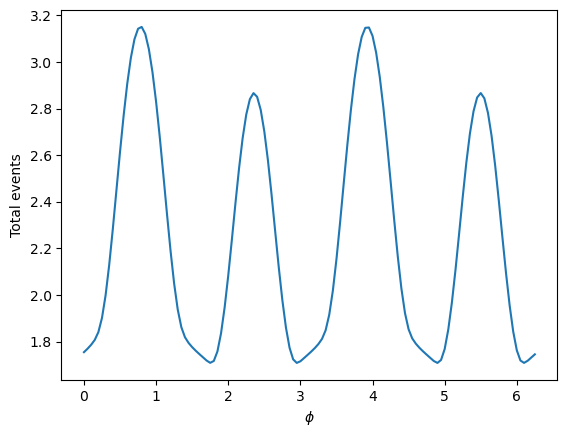

In [60]:
phi_axis =  np.arange(0, 2*np.pi, 0.05)
y_axis = []
for phi in phi_axis:
    y_axis.append(complete_dndt(k = [np.cos(phi), np.sin(phi), 0], abs_forgot=True))

plt.plot(phi_axis, y_axis)
plt.xlabel("$\phi$")
plt.ylabel("Total events")

making a 2d grid of theta and phi shouldn't be super difficult actually

if I feel like it plotly might be able to essentially map the points to a 2-sphere

In [61]:
phi_axis =  np.arange(0, 2*np.pi, 0.05)
theta_axis = np.arange(0,np.pi, 0.05)
angle_plane = np.array(list(itertools.product(phi_axis, theta_axis)))

def angle_dependence():
    outputs = []
    for angles in angle_plane:
        phi = angles[0]
        theta = angles[1]
        k_vec = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        outputs.append(complete_dndt(k = k_vec, abs_forgot = True))
    return np.array(outputs)

rates_on_angle = angle_dependence()

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2680214342.py:31: RuntimeWarning:

divide by zero encountered in divide

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2170456216.py:59: RuntimeWarning:

overflow encountered in exp



In [62]:
dict = {"phi"  : angle_plane[:,1],
        "theta": angle_plane[:,0],
        "rate" : rates_on_angle}
df = pd.DataFrame(dict)

fig = px.scatter(df, x="phi", y="theta", color="rate", color_continuous_scale="Turbo")
fig.show()

In [63]:
fig = px.scatter_3d(
    x = np.sin(df["theta"])*np.cos(df["phi"]),
    y = np.sin(df["theta"])*np.sin(df["phi"]),
    z = np.cos(df["theta"]),
    color=df["rate"], color_continuous_scale="Turbo"
)
fig.show()

C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2680214342.py:31: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV #I lied this depends on k as well
C:\Users\taase\AppData\Local\Temp\ipykernel_5496\2170456216.py:59: RuntimeWarning: overflow encountered in exp
  dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))


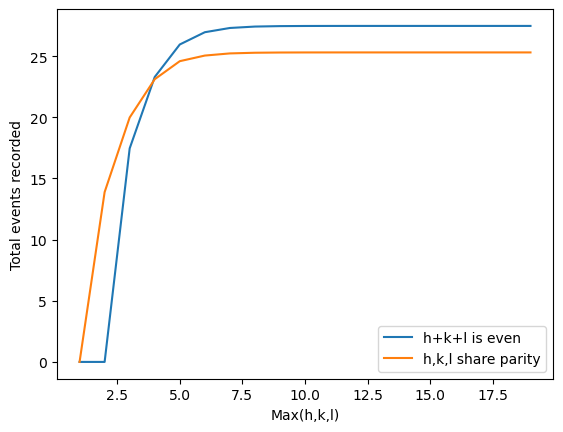

In [21]:
hkl_max_list = range(1,20)
s_axis = []
f_axis = []
for x_value in hkl_max_list:
    s_axis.append(complete_dndt(max_hkl=x_value, F=False))
    f_axis.append(complete_dndt(max_hkl=x_value, F=True ))

plt.plot(hkl_max_list, s_axis)
plt.plot(hkl_max_list, f_axis)
plt.legend(["h+k+l is even", "h,k,l share parity"])
plt.xlabel("Max(h,k,l)")
plt.ylabel("Total events recorded")
plt.show()

In [22]:
total_sum = (dphi_de*1e-16)*W*FAq*sin2*4/mod2_g
nt_constant*np.sum(total_sum)

2.8433877821443136e-09

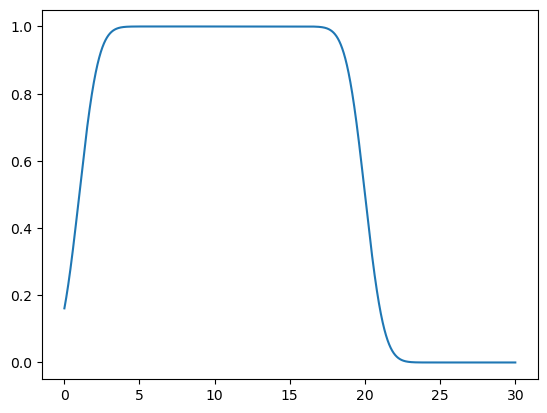

In [7]:
x_axis = np.arange(0.01,30,0.001)
y_axis = w_func(x_axis, dVector=False, Delta = 1, E1=1, E2=20)

plt.plot(x_axis, y_axis)
plt.show()

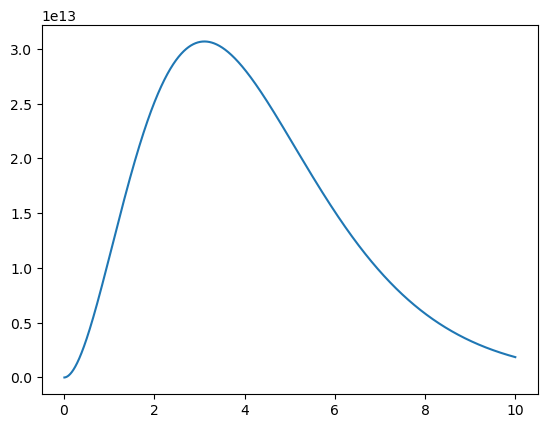

In [24]:
plt.plot(x_axis, make_dpde(x_axis))
plt.show()

In [25]:
dpde_unit = dphi_de*unit.cm**(-2)*unit.s**(-1)*unit.keV**(-1)
mod2g_unit = (mod2_g)*unit.AA**(-2)
(dpde_unit/mod2g_unit).to(unit.s**(-1)*unit.keV**(-1))

<Quantity [1.65071362e-06, 2.04671403e-08, 6.59218250e-06, 8.25356809e-07,
           2.13956410e-08, 1.65071362e-06, 2.04972230e-06, 2.64864182e-07,
           8.25356809e-07, 5.50237872e-07, 7.29153086e-08, 2.04671403e-08,
           2.64864182e-07, 1.34365967e-07, 2.13956410e-08, 7.29153086e-08,
           3.08894975e-08, 0.00000000e+00, 4.09342806e-08, 5.97204004e-10,
           0.00000000e+00, 4.09944459e-06, 1.45830617e-07, 4.09944459e-06,
           1.34714063e-06, 7.88490563e-08, 4.09342806e-08, 1.34714063e-06,
           3.85387764e-07, 1.45830617e-07, 3.85387764e-07, 9.93183811e-08,
           5.97204004e-10, 7.88490563e-08, 9.93183811e-08, 2.64615644e-04,
           0.00000000e+00, 2.90835109e-11, 0.00000000e+00, 1.54447487e-07,
           5.12809067e-09, 0.00000000e+00, 1.65071362e-06, 2.68731934e-07,
           1.54447487e-07, 8.25356809e-07, 1.19548262e-07, 2.90835109e-11,
           2.68731934e-07, 2.64864182e-07, 5.12809067e-09, 1.19548262e-07,
           7.29153086e-08

In [26]:
1e-16*dphi_de/mod2_g

array([1.65071362e-06, 2.04671403e-08, 6.59218250e-06, 8.25356809e-07,
       2.13956410e-08, 1.65071362e-06, 2.04972230e-06, 2.64864182e-07,
       8.25356809e-07, 5.50237872e-07, 7.29153086e-08, 2.04671403e-08,
       2.64864182e-07, 1.34365967e-07, 2.13956410e-08, 7.29153086e-08,
       3.08894975e-08, 0.00000000e+00, 4.09342806e-08, 5.97204004e-10,
       0.00000000e+00, 4.09944459e-06, 1.45830617e-07, 4.09944459e-06,
       1.34714063e-06, 7.88490563e-08, 4.09342806e-08, 1.34714063e-06,
       3.85387764e-07, 1.45830617e-07, 3.85387764e-07, 9.93183811e-08,
       5.97204004e-10, 7.88490563e-08, 9.93183811e-08, 2.64615644e-04,
       0.00000000e+00, 2.90835109e-11, 0.00000000e+00, 1.54447487e-07,
       5.12809067e-09, 0.00000000e+00, 1.65071362e-06, 2.68731934e-07,
       1.54447487e-07, 8.25356809e-07, 1.19548262e-07, 2.90835109e-11,
       2.68731934e-07, 2.64864182e-07, 5.12809067e-09, 1.19548262e-07,
       7.29153086e-08, 1.05190065e-03, 0.00000000e+00, 5.57875957e-16,
      